In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
image = mpimg.imread('test_images/test1.jpg')
cars = glob.glob('vehicles_smallset/*/*.jpeg')
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
cl=len(cars)
ncl = len(notcars)
if cl < ncl:
    notcars = notcars[0:cl]
elif ncl < cl:
    cars = cars[0:ncl]

#cars = []
#notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)
        


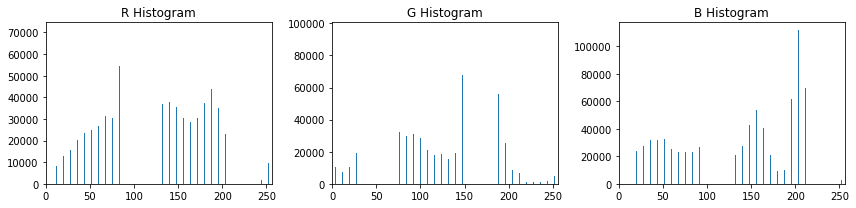

In [19]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Take histograms in R, G, and B
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    hist_features = np.ravel(hist_features)
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()    
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

In [20]:
#import Axes3D to plot 3D diagrams
from mpl_toolkits.mplot3d import Axes3D

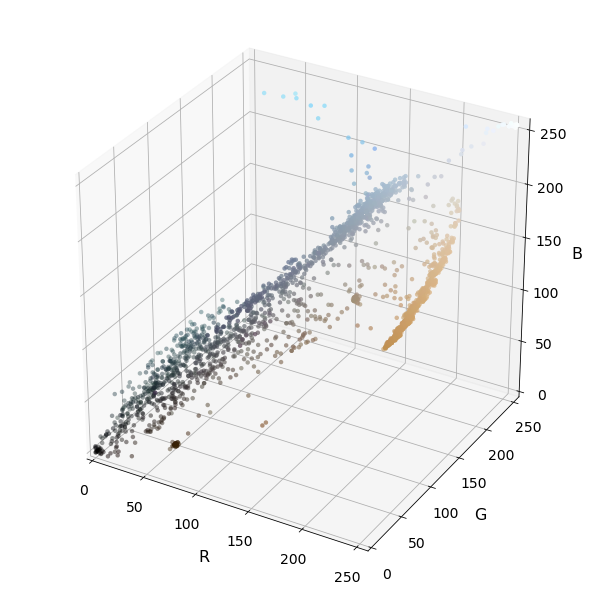

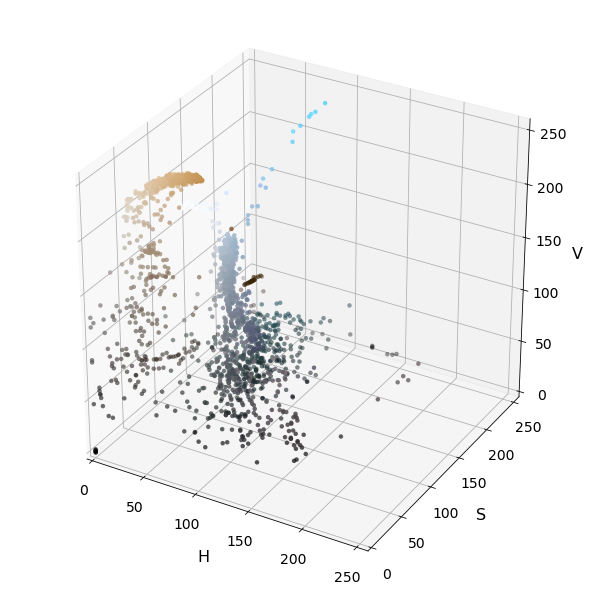

In [21]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    #"""Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

img = image
# Read a color image
#img = cv2.imread("000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

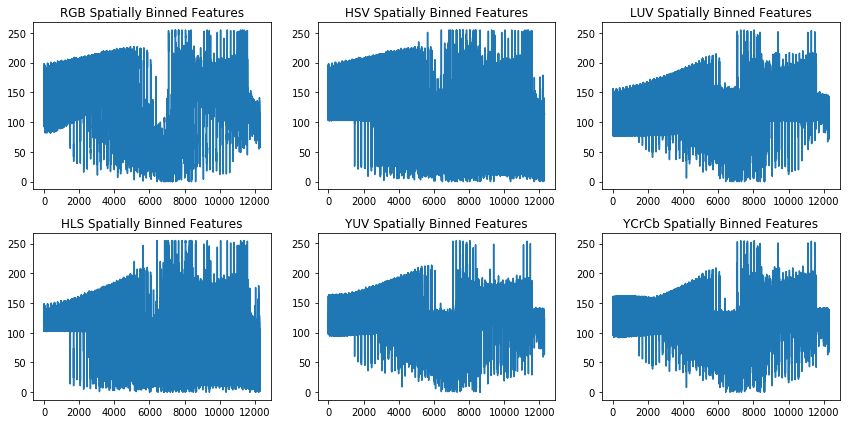

In [22]:
def bin_spatial(img, color_space='RGB', size = (32,32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
bin_size = (64,64)
#bin_size = (image.shape[0],image.shape[1])
feature_vec = bin_spatial(image, color_space='RGB', size = bin_size)
fig = plt.figure(figsize=(12,6))
plt.subplot(231)
plt.plot(bin_spatial(image, color_space='RGB', size = bin_size))
plt.title('RGB Spatially Binned Features')
plt.subplot(232)
plt.plot(bin_spatial(image, color_space='HSV', size = bin_size))
plt.title('HSV Spatially Binned Features')
plt.subplot(233)
plt.plot(bin_spatial(image, color_space='LUV', size = bin_size))
plt.title('LUV Spatially Binned Features')
plt.subplot(234)
plt.plot(bin_spatial(image, color_space='HLS', size = bin_size))
plt.title('HLS Spatially Binned Features')
plt.subplot(235)
plt.plot(bin_spatial(image, color_space='YUV', size = bin_size))
plt.title('YUV Spatially Binned Features')
plt.subplot(236)
plt.plot(bin_spatial(image, color_space='YCrCb', size = bin_size))
plt.title('YCrCb Spatially Binned Features')
fig.tight_layout()# Plot features
plt.show()

In [23]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

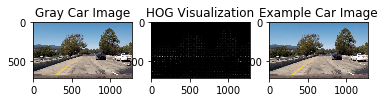

In [147]:

image = mpimg.imread('test_images/test1.jpg')
#Lecture 20
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,block_norm="L2-Hys")
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,block_norm="L2-Hys")
        return features
# Define a function to return HOG features and visualization
#def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
#    if vis == True:
#        features, hog_image = hog(img, orientations=orient,
#                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                          visualise=True, feature_vector=False,
#                          block_norm="L2-Hys")
#        return features, hog_image
#    else:
#        # Use skimage.hog() to get features only
#        features = hog(img, orientations=orient,
#                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
#                          visualise=False, feature_vector=False,
#                          block_norm="L2-Hys")
#        return features

#i = cv2.resize(image,(64,64))
i = image
gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(3)
plt.subplot(131)
plt.imshow(i)
plt.title('Gray Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.imshow(image)
plt.title('Example Car Image')
plt.show()

In [152]:
from sklearn.preprocessing import StandardScaler
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, apply_bin = True, apply_hist = True, apply_hog = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.resize(image, spatial_size)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        i_features = []
        if apply_hog == True:
            if hog_channel == 'ALL':
                hog_features = []        
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            i_features.append(hog_features)
        if apply_bin == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            i_features.append(spatial_features)
        #print(spatial_features.shape)
        # Apply color_hist() also with a color space option now
        if apply_hist == True:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            i_features.append(hist_features)
        #print(hist_features.shape)
        # Append the new feature vector to the features list
        #print(len(spatial_features),len(hist_features))
        features.append(np.concatenate(i_features))
        #print(features[-1].shape)
    # Return list of feature vectors
    return features

In [153]:
import sklearn
print("I am using : ",sklearn.__version__)
from sklearn.model_selection import train_test_split

I am using :  0.19.0


In [154]:
import time
def train_features(car_features, notcar_features, vis = False):
    if len(car_features) > 0 and len(notcar_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)  
        #X = v
        # Fit a per-column scalesr
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        car_ind = np.random.randint(0, len(cars))
        #print(cars[car_ind])
        if vis:
            # Plot an example of raw and scaled features
            fig = plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.imshow(mpimg.imread(cars[car_ind]))
            plt.title('Original Image')
            plt.subplot(132)
            plt.plot(X[car_ind])
            plt.title('Raw Features')
            plt.subplot(133)
            plt.plot(scaled_X[car_ind])
            plt.title('Normalized Features')
            fig.tight_layout()
            plt.show()
        else: 
            print('Your function only returns empty feature vectors...')
        
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    print('Train samples length:', len(X_train))
    print('Test samples length:', len(X_test))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return 

1125
1125


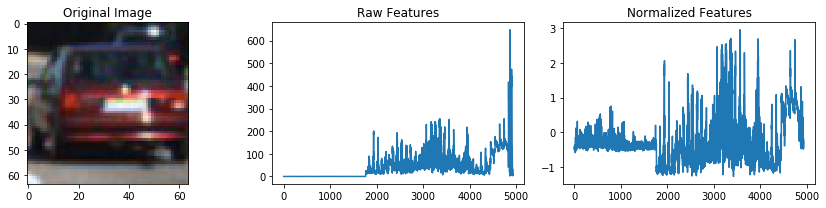

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4932
Train samples length: 1800
Test samples length: 450
2.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9933
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.003 Seconds to predict 10 labels with SVC


In [155]:
# performs under different binning scenarios
spatial = 32
histbin = 32
car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(car_features))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(notcar_features))
train_features(car_features, notcar_features, vis = True)

In [156]:
hog_channel='ALL'
#hog_channel='ALL'
car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),hog_channel=hog_channel)
train_features(car_features, notcar_features)

Your function only returns empty feature vectors...
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460
Train samples length: 1800
Test samples length: 450
4.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9844
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
0.003 Seconds to predict 10 labels with SVC
